In this notebook we simulate a regression and have a look at the difference between the predictions generated by an overspecified OLS model, a more parsimonious model estimated using lasso, an OLS model that is selected using the AIC criterion

In [88]:
# install.packages(c("MASS", "caret", "glmnet"),repos="http://cran.rstudio.com/" )

In [128]:
library("MASS")
set.seed(11)

n_vars <- 4 #number of x variables
corr <- 0.4 #correlation between x to build multicolinearity
nobs <- 1000 #number of rows in dataset
error_sd <- 10
intercept <- 5

#Build variance covariance matrix between variables, here
#it's 1s on the diagonal
m <- matrix(rep(0.5,n_vars^2), n_vars)
diag(m) <- 1

#Build dataset - num vars, mean, and covariance matrix.
X <- mvrnorm(n = nobs, rep(0, n_vars), m,  tol = 1e-6)
e <- rnorm(nobs,0,error_sd)

#Model
b <- c(10,12,0,0)
y <- intercept + X %*% b + e

df <- data.frame(e, y, X)

#Split into a test and a training set
library(caret)
trainIndex <- createDataPartition(df$y, p = .75,
                                  list = FALSE,
                                  times = 1)

df_train <- df[ trainIndex,]
df_test  <- df[-trainIndex,]

train_for_model <- df_train[,-1] #to prevent putting the e as explanatory variable

In [129]:
#Fit the real model
lm_real <- lm(y~X1 + X2, data=train_for_model)
summary(lm_real) #Note coefficients are quite close to reality


Call:
lm(formula = y ~ X1 + X2, data = train_for_model)

Residuals:
     Min       1Q   Median       3Q      Max 
-31.1104  -7.4369   0.0882   6.9643  28.0831 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   5.5536     0.3630   15.30   <2e-16 ***
X1           10.3028     0.4208   24.49   <2e-16 ***
X2           12.0474     0.4263   28.26   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 9.952 on 749 degrees of freedom
Multiple R-squared:  0.7884,	Adjusted R-squared:  0.7879 
F-statistic:  1396 on 2 and 749 DF,  p-value: < 2.2e-16


In [91]:
#Fit a linear model with all cross terms 
quadratic_terms <- paste("I(",names(train_for_model)[-1], "^2)",collapse="+")
reg_formula <- paste("y~.^3 + ", quadratic_terms)
lm_overfit <- lm(reg_formula, data=train_for_model)
coef_overfit <- coef(lm_fit)
summary(lm_overfit) #Note the coefficients are much less accurate

ERROR: Error in coef(lm_fit): object 'lm_fit' not found



Call:
lm(formula = reg_formula, data = train_for_model)

Residuals:
    Min      1Q  Median      3Q     Max 
-34.536  -6.734   0.128   6.817  29.277 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  5.38665    0.66483   8.102 2.25e-15 ***
X1           9.79645    0.51467  19.034  < 2e-16 ***
X2          12.03735    0.53718  22.408  < 2e-16 ***
X3          -0.14008    0.52505  -0.267   0.7897    
X4          -0.08910    0.51286  -0.174   0.8621    
I(X1^2)     -0.28936    0.39832  -0.726   0.4678    
I(X2^2)      0.35010    0.42644   0.821   0.4119    
I(X3^2)      0.09760    0.42993   0.227   0.8205    
I(X4^2)     -0.89281    0.37991  -2.350   0.0190 *  
X1:X2       -0.84350    0.60761  -1.388   0.1655    
X1:X3        0.34903    0.61035   0.572   0.5676    
X1:X4        1.08900    0.57249   1.902   0.0575 .  
X2:X3       -0.50335    0.60020  -0.839   0.4019    
X2:X4        0.53323    0.60623   0.880   0.3794    
X3:X4        0.17664    0.59059   0.299

In [92]:
#Now let's estimate the same model with LASSO
library(glmnet)
in_matrix_form_for_glmnet <- model.matrix(y ~ .^3 + I(X1^2) + I(X2^2) + I(X3^2) + I(X4^2), data=train_for_model)
fit_lasso<-glmnet(in_matrix_form_for_glmnet,train_for_model$y,lambda=seq(1,0.01,-0.01))

In [93]:
#Cross validate the model
fit_lasso_cv <- cv.glmnet(in_matrix_form_for_glmnet,train_for_model$y,lambda=seq(1,0.01,-0.01))

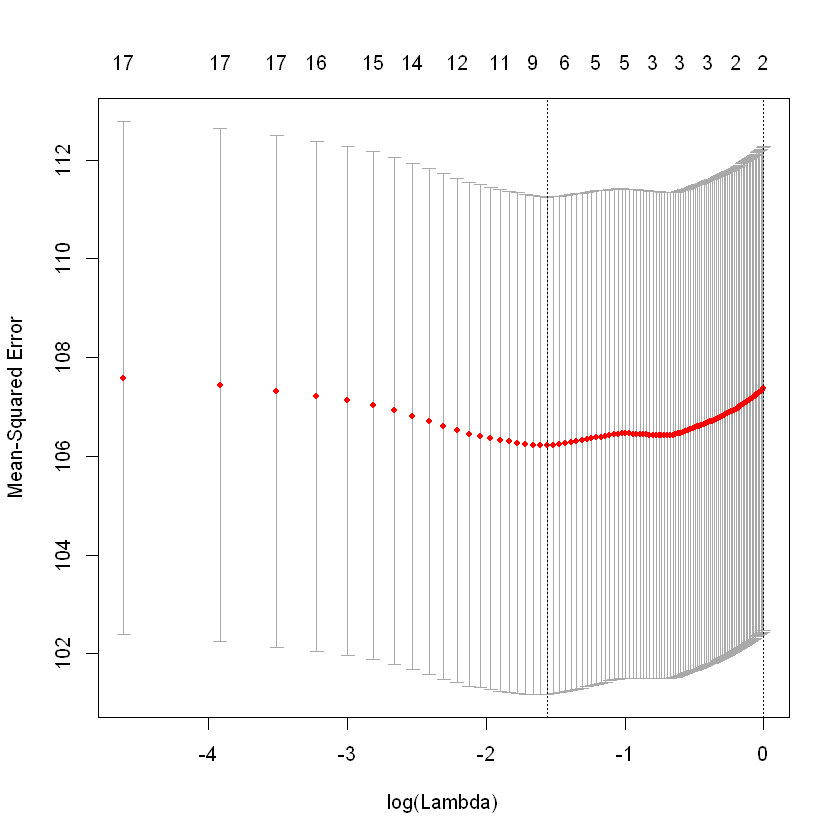

In [94]:
plot(fit_lasso_cv) 

In [95]:
#Take the 'optimal' lambda parameter, as chosen by cross validation, and print the parameter estimatates
best <- glmnet(in_matrix_form_for_glmnet,train_for_model$y,lambda=fit_lasso_cv$lambda.min)
print(best$a0)
print(best$beta)
print(fit_lasso_cv$lambda.min)

      s0 
5.105298 
19 x 1 sparse Matrix of class "dgCMatrix"
                      s0
(Intercept)  .          
X1           9.649505757
X2          11.966714529
X3           .          
X4           .          
I(X1^2)      .          
I(X2^2)      .          
I(X3^2)      0.002394588
I(X4^2)     -0.273587316
X1:X2       -0.138709037
X1:X3        .          
X1:X4        0.454200173
X2:X3        .          
X2:X4        .          
X3:X4        .          
X1:X2:X3     .          
X1:X2:X4     0.204800815
X1:X3:X4     .          
X2:X3:X4     .          
[1] 0.21


In [96]:
#OPTIONAL
#Do the same thing in caret
#Note that the optimal lambda depends on the (randomly selected) k folds so varies on each run

# library('caret')

# eGrid <- expand.grid(.alpha = 1, #Note that alpha=1 is the default and means lasso (alpha=0 is ridge) 
#                      .lambda = (1:100) * 0.01)

# Control <- trainControl(method = "cv",number = 10,verboseIter =TRUE)

# train(y ~ .^3 + I(X1^2) + I(X2^2) + I(X3^2) + I(X4^2),
#     train_for_model,
#     method="glmnet",
#     tuneGrid =eGrid,
#     trControl = Control
#      )

+ Fold01: alpha=1, lambda=1 
- Fold01: alpha=1, lambda=1 
+ Fold02: alpha=1, lambda=1 
- Fold02: alpha=1, lambda=1 
+ Fold03: alpha=1, lambda=1 
- Fold03: alpha=1, lambda=1 
+ Fold04: alpha=1, lambda=1 
- Fold04: alpha=1, lambda=1 
+ Fold05: alpha=1, lambda=1 
- Fold05: alpha=1, lambda=1 
+ Fold06: alpha=1, lambda=1 
- Fold06: alpha=1, lambda=1 
+ Fold07: alpha=1, lambda=1 
- Fold07: alpha=1, lambda=1 
+ Fold08: alpha=1, lambda=1 
- Fold08: alpha=1, lambda=1 
+ Fold09: alpha=1, lambda=1 
- Fold09: alpha=1, lambda=1 
+ Fold10: alpha=1, lambda=1 
- Fold10: alpha=1, lambda=1 
Aggregating results
Selecting tuning parameters
Fitting alpha = 1, lambda = 0.45 on full training set


glmnet 

752 samples
  4 predictor

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 678, 677, 676, 677, 676, 676, ... 
Resampling results across tuning parameters:

  lambda  RMSE      Rsquared   RMSE SD   Rsquared SD
  0.01    10.32667  0.7733081  1.178281  0.04497805 
  0.02    10.32515  0.7733754  1.178286  0.04498403 
  0.03    10.31765  0.7737271  1.176061  0.04489030 
  0.04    10.31092  0.7740475  1.173785  0.04477998 
  0.05    10.30487  0.7743401  1.171299  0.04466960 
  0.06    10.29949  0.7746076  1.170336  0.04459121 
  0.07    10.29472  0.7748531  1.169576  0.04450627 
  0.08    10.29027  0.7750832  1.169040  0.04443099 
  0.09    10.28592  0.7753106  1.168354  0.04435877 
  0.10    10.28165  0.7755346  1.167732  0.04429526 
  0.11    10.27783  0.7757329  1.167145  0.04423309 
  0.12    10.27412  0.7759183  1.166692  0.04417438 
  0.13    10.27017  0.7761132  1.165803  0.04408519 
  0.14    10.26649  0.7762983  1.164552  0.04398468 
  0.15

In [97]:
#Automated model selection using AIC
# install.packages("MuMIn",repos="http://cran.rstudio.com/")
library("MuMIn")
options(na.action = "na.fail")
fm1 <- lm(reg_formula, data = train_for_model)
ms1 <- dredge(fm1)


Fixed term is "(Intercept)"


In [98]:
h <- head(ms1,3)
h[,(!(is.na(h[3,])))]

,(Intercept),X1,X2,X4,I(X4^2),X1:X4,df,logLik,AICc,delta
6,4.985332,9.892905,12.23761,NA,NA,NA,4,-2817.923,5643.9,0
134,5.246714,9.900892,12.23069,NA,-0.262578,NA,5,-2817.407,5644.895,0.9949805
1222,5.254774,9.938167,12.20154,0.00550713,-0.6248039,0.7841162,7,-2815.49,5645.13,1.230399


In [99]:
#Now we have the various models, use them to make predictions
#Note that the AIC model selects the correct X variables so in this case we expect it to win

In [100]:
#Probably the best metric for which model predicts with the lowest mean squared error on the test set

In [130]:
#The best possible model is the real model (anything better is just an overfit) - here's the mean squared error calculation:

#We can compare the predictions to the test set.  Or we can compare the predictions to the best possible prediction from the true model

#The following is the best possible, if we predicted correctly the true parameters
sd(df_test$e)

[1] 9.915317

In [131]:
#Try the model produced by the initial linear model.
#This is unattainable in reality since this one assumes we know the model
df_test$estimated_from_known_dependent <- predict(lm_real, newdata=df_test)

sd(df_test$estimated_from_known_dependent - df_test$y) 

[1] 9.949634

In [135]:
#Try the model produced by the liner model with superfluous variables.  Clearly predicts worse
df_test$estimated_from_known_dependent <- predict(lm_overfit, newdata=df_test)

sd(df_test$estimated_from_known_dependent - df_test$y) 

[1] 10.01372

In [168]:
#Try the model produced by lasso
matrix_for_pred <- model.matrix(y ~ .^3 + I(X1^2) + I(X2^2) + I(X3^2) + I(X4^2), data=df_test[,c(2:6)])
df_test$estimated_from_known_dependent <- predict(best,matrix_for_pred)

sd(df_test$estimated_from_known_dependent - df_test$y) 

[1] 9.892556

In [ ]:
#And findally the model chosen by AIC is the same as the initial linear model from known 
#dependent variables, so in this specific example the AIC methodology is best.  (But 
#in general this will vary depending on the DGP)